Test on processing of ground truth images and the projected centerline and contour

In [1]:
import sys
sys.path.append('..')

import numpy as np
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
import torch
import cv2
from test_reconst_v2 import ConstructionBezier
from test_loss_define_v2 import ContourChamferLoss, TipDistanceLoss, GenerateRefData
import torch.nn as nn
import matplotlib.pyplot as plt


Camera Intrinsics:
[[883.00220751   0.         320.        ]
 [  0.         883.00220751 240.        ]
 [  0.           0.           1.        ]]
Camera Extrinsics:
[[-1.00000000e+00 -1.22464680e-16  1.49975978e-32  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### Test on the processing of ground truth images

In [2]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [3]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [4]:
if torch.cuda.is_available():
    gpu_or_cpu = torch.device("cuda:0") 
    torch.cuda.set_device(gpu_or_cpu)
else:
    gpu_or_cpu = torch.device("cpu")

case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
# case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_gt_4'
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '.npy'

In [5]:
p_start_np = np.load(cc_specs_path)[0, 0, :] + 1e-8
print(p_start_np)

[2.000001e-02 2.000010e-03 1.000000e-08]


In [6]:
para_gt_np = read_gt_params(cc_specs_path)
print("Ground truth parameters: ", para_gt_np)

p_start = torch.tensor([2e-2, 2e-3, 1e-8]).to(gpu_or_cpu) # 0 here will cause NaN in draw2DCylinderImage, pTip
# para_init = np.array([0.13, 0.12, 0.9, 0.06, 0.033, 0.5],
#                     dtype=np.float32)
para_init = nn.Parameter(torch.from_numpy(para_gt_np).to(gpu_or_cpu),
                                      requires_grad=True)


img_ref_binary = process_image(img_save_path)

image_ref = torch.from_numpy(img_ref_binary.astype(np.float32)).to(gpu_or_cpu)

Ground truth parameters:  [ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01
 -2.39781477e-01  9.49010349e-01]


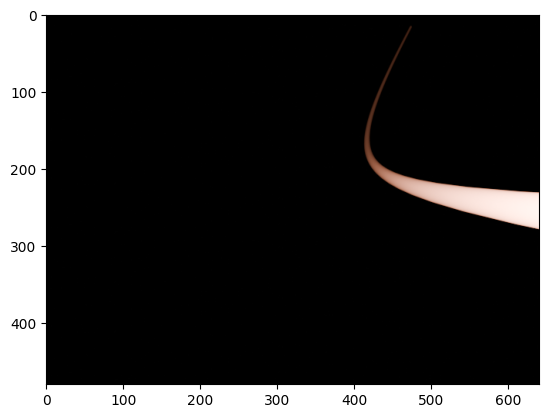

In [7]:
img_ref_rgb = cv2.imread(img_save_path)
img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(img_ref_rgb)

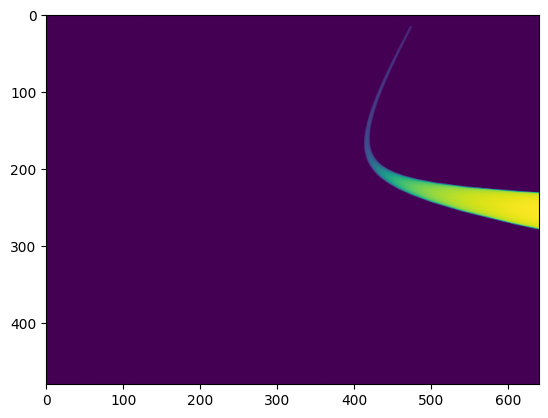

In [8]:
np.savetxt('img_ref_gray.txt', img_ref_gray, fmt='%d')
plt.imshow(img_ref_gray)

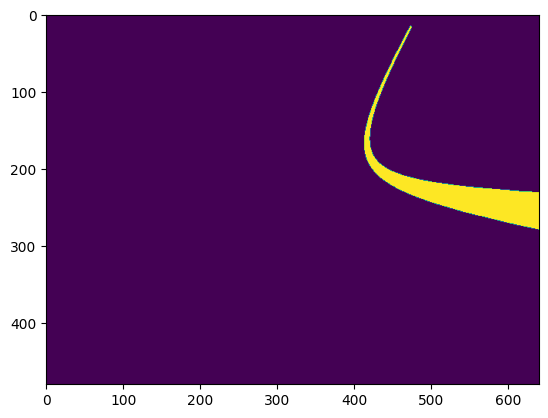

In [9]:
plt.imshow(img_ref_binary)

### Test on draw2DCylinderImage()
Be careful with the selection of tip and base on the centerline.

Note that tip is self.bezier_proj_centerline_img[-1, :], not [0. :]. So it's currently right in TipDistanceLoss

In [10]:

save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_old/initial_frame_10.png'

build_bezier = ConstructionBezier()
build_bezier.to(gpu_or_cpu)
build_bezier.loadRawImage(img_save_path)
build_bezier.getBezierCurveCylinder(p_start, para_init)
build_bezier.getCylinderMeshProjImg()
build_bezier.getBezierProjImg()
build_bezier.draw2DCylinderImage(image_ref, save_img_path)

array([[[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [11]:
bezier_proj_img = build_bezier.bezier_proj_img.detach().numpy()
bezier_proj_centerline_img = build_bezier.bezier_proj_centerline_img.detach().numpy()
print("Shape of bezier_proj_img", bezier_proj_img.shape)
print("Shape of bezier_proj_centerline_img", bezier_proj_centerline_img.shape)
img_render_point_cloud = bezier_proj_img.reshape(bezier_proj_img.shape[0] * bezier_proj_img.shape[1], 2)
print("Shape of img_render_point_cloud", img_render_point_cloud.shape)

Shape of bezier_proj_img (30, 30, 2)
Shape of bezier_proj_centerline_img (30, 2)
Shape of img_render_point_cloud (900, 2)


#### Test on the projected centerline
There are points in the data that are out of the range of the picture, and there are also obvious outliers (extremely large values) that do interfere. There is no need to remove these outliers though, as the tip loss only requires selecting the tip from centerline.

Also mind the selection of tip and base point from centerline.

In [12]:
print(bezier_proj_centerline_img)

[[1.76600474e+09 1.76600695e+08]
 [8.24222558e+02 2.78270544e+02]
 [5.80476956e+02 2.46426281e+02]
 [5.02073572e+02 2.31074175e+02]
 [4.65023838e+02 2.19815004e+02]
 [4.44530208e+02 2.10168655e+02]
 [4.32326966e+02 2.01308197e+02]
 [4.24871748e+02 1.92879018e+02]
 [4.20393511e+02 1.84703646e+02]
 [4.17908451e+02 1.76683315e+02]
 [4.16826331e+02 1.68758634e+02]
 [4.16771654e+02 1.60891656e+02]
 [4.17494173e+02 1.53056974e+02]
 [4.18820692e+02 1.45236852e+02]
 [4.20627561e+02 1.37418558e+02]
 [4.22824190e+02 1.29592606e+02]
 [4.25342683e+02 1.21751793e+02]
 [4.28131168e+02 1.13890545e+02]
 [4.31149373e+02 1.06004416e+02]
 [4.34365537e+02 9.80897618e+01]
 [4.37754331e+02 9.01436600e+01]
 [4.41295281e+02 8.21636244e+01]
 [4.44971664e+02 7.41475365e+01]
 [4.48769743e+02 6.60935674e+01]
 [4.52678110e+02 5.80001777e+01]
 [4.56687227e+02 4.98658673e+01]
 [4.60789026e+02 4.16894653e+01]
 [4.64976733e+02 3.34697743e+01]
 [4.69244570e+02 2.52057679e+01]
 [4.73587551e+02 1.68964462e+01]]


Projected tip (473, 16)


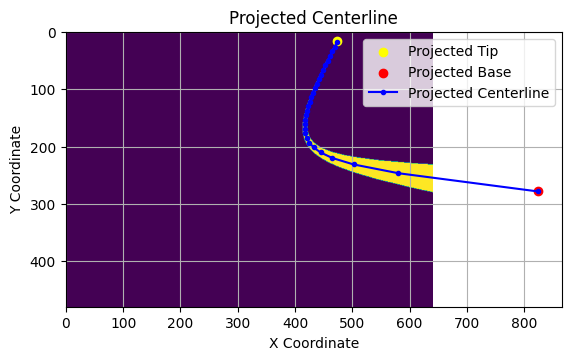

In [13]:
projected_base = (int(bezier_proj_centerline_img[1, 0]), int(bezier_proj_centerline_img[1, 1]))
projected_tip = (int(bezier_proj_centerline_img[-1, 0]), int(bezier_proj_centerline_img[-1, 1]))
print("Projected tip", projected_tip)

x = bezier_proj_centerline_img[1:, 0]
y = bezier_proj_centerline_img[1:, 1]

# 绘制这些坐标点
# plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)

plt.scatter(projected_tip[0], projected_tip[1], color='yellow', label='Projected Tip')  
plt.scatter(projected_base[0], projected_base[1], color='red', label='Projected Base')

plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Centerline', markersize=3)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Projected Centerline')
plt.legend()
plt.grid(True)
plt.show()

#### Test on projected contour point cloud
Points that are out of range and obvious outliers also exists, which must be removed to compute the contour loss.

In [14]:
print(img_render_point_cloud)
np.savetxt('data.txt', img_render_point_cloud, fmt='%d')

[[-3.98799272e+06 -3.62328715e+05]
 [-6.09497008e+06 -6.43224523e+05]
 [-1.42423719e+07 -1.70996314e+06]
 ...
 [ 4.74707974e+02  1.60413498e+01]
 [ 4.74859854e+02  1.62897420e+01]
 [ 4.74956063e+02  1.65646076e+01]]


In [20]:
mask = (img_render_point_cloud[:, 0] >= 0) & (img_render_point_cloud[:, 0] <= 640) & (img_render_point_cloud[:, 1] >= 0) & (img_render_point_cloud[:, 1] <= 480)
img_render_point_cloud = img_render_point_cloud[mask]
print(img_render_point_cloud.shape)

# downsampling
num_points = 100
n = img_render_point_cloud.shape[0]
step = n // num_points
indices = np.arange(0, n, step)
img_render_point_cloud = img_render_point_cloud[indices]

(840, 2)


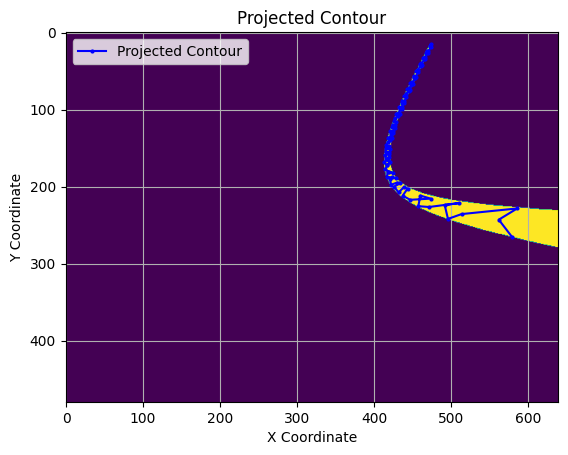

In [21]:
x = img_render_point_cloud[1:, 0]
y = img_render_point_cloud[1:, 1]


plt.imshow(img_ref_binary)
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Contour', markersize=2)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Projected Contour')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
image_ref = torch.from_numpy(img_ref_binary.astype(np.float32))
generate_ref_data = GenerateRefData(image_ref)
ref_catheter_contour = generate_ref_data.get_raw_contour()
ref_catheter_centerline = generate_ref_data.get_raw_centerline()

contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
loss_contour = contour_chamfer_loss(build_bezier.bezier_proj_img.to(gpu_or_cpu), ref_catheter_contour.to(gpu_or_cpu))
tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
loss_tip_distance, _ = tip_distance_loss(build_bezier.bezier_proj_centerline_img.to(gpu_or_cpu), ref_catheter_centerline.to(gpu_or_cpu))


In [23]:
print("Loss contour", loss_contour)
print("Loss tip distance", loss_tip_distance)
# print(contour_chamfer_loss.img_render_point_cloud)

Loss contour tensor(3.1799, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
Loss tip distance tensor(0.1780, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
